In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:
df_adj = pd.read_csv('adjacency.csv')
df_attributes = pd.read_excel('attributes.xlsx')
df_seed = pd.read_excel('seed.xlsx', header=None)
G = df_adj.to_numpy()

plotting the attributes with some of the seed points

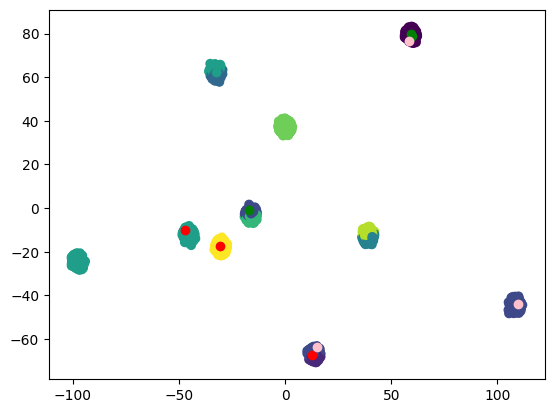

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_attributes_pca = pca.fit_transform(df_attributes)
df_attributes_pca = pd.DataFrame(df_attributes_pca, columns=['pca1', 'pca2'])

import matplotlib.pyplot as plt
plt.scatter(df_attributes_pca['pca1'], df_attributes_pca['pca2'])

plt.scatter(df_attributes_pca.loc[5793, 'pca1'], df_attributes_pca.loc[5793, 'pca2'], color='red')
plt.scatter(df_attributes_pca.loc[10805, 'pca1'], df_attributes_pca.loc[10805, 'pca2'], color='red')
plt.scatter(df_attributes_pca.loc[2258, 'pca1'], df_attributes_pca.loc[2258, 'pca2'], color='red')

plt.scatter(df_attributes_pca.loc[8938, 'pca1'], df_attributes_pca.loc[8938, 'pca2'], color='green')
plt.scatter(df_attributes_pca.loc[7423, 'pca1'], df_attributes_pca.loc[7423, 'pca2'], color='green')
plt.scatter(df_attributes_pca.loc[1853, 'pca1'], df_attributes_pca.loc[1853, 'pca2'], color='green')

plt.scatter(df_attributes_pca.loc[4566, 'pca1'], df_attributes_pca.loc[4566, 'pca2'], color='pink')
plt.scatter(df_attributes_pca.loc[902, 'pca1'], df_attributes_pca.loc[902, 'pca2'], color='pink')
plt.scatter(df_attributes_pca.loc[5633, 'pca1'], df_attributes_pca.loc[5633, 'pca2'], color='pink')

plt.show()

## Spectral clustering using pairwise distance and adj matrix

Computing pairwise distances and making a weighted graph

In [ ]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(df_attributes_pca, metric='euclidean')

In [ ]:

G_1 = np.zeros((len(G), len(G)))
for i in range(len(G_1)):
    for j in range(len(G_1[i])):
        if G[i][j] == 1:
             G_1[i][j] = 1/D[i][j]
G_1

array([[0.        , 0.01310394, 0.        , ..., 0.        , 0.01174444,
        0.01658674],
       [0.01310394, 0.        , 0.        , ..., 0.        , 0.00631478,
        0.01022542],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01392892],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.01141071,
        0.        ],
       [0.01174444, 0.00631478, 0.        , ..., 0.01141071, 0.        ,
        0.01208898],
       [0.01658674, 0.01022542, 0.01392892, ..., 0.        , 0.01208898,
        0.        ]])

In [ ]:
D

array([[  0.        ,  76.30746998,  54.68604405, ...,   2.51882662,
         85.14704278,  60.29769188],
       [ 76.30746998,   0.        , 130.27042154, ...,  73.86260315,
        158.35745481,  97.80115334],
       [ 54.68604405, 130.27042154,   0.        , ...,  57.20407226,
         32.83256208,  71.8100337 ],
       ...,
       [  2.51882662,  73.86260315,  57.20407226, ...,   0.        ,
         87.63689875,  60.97091474],
       [ 85.14704278, 158.35745481,  32.83256208, ...,  87.63689875,
          0.        ,  82.73068121],
       [ 60.29769188,  97.80115334,  71.8100337 , ...,  60.97091474,
         82.73068121,   0.        ]])

Performing spectral clustering on the weighted graph

In [68]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10,affinity='precomputed', assign_labels='discretize')

sc.fit(G_1)
sc.get_params

SpectralClustering(affinity='precomputed', assign_labels='discretize',
                   n_clusters=10)

In [61]:
print(sc.labels_)

[2 0 1 ... 2 1 8]


In [69]:
print(sc.labels_[df_seed.iloc[:,0].to_numpy()])
print(sc.labels_[df_seed.iloc[:,1].to_numpy()])
print(sc.labels_[df_seed.iloc[:,2].to_numpy()])

[5 9 0 7 2 1 4 7 6 3]
[4 2 4 2 7 9 2 3 2 4]
[6 2 2 8 1 4 6 7 4 8]


## Deepwalk


In [26]:
from gensim.models import Word2Vec
import networkx as nx

In [27]:
# creating networkx graph
G_nx = nx.from_numpy_matrix(G)

In [28]:
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]
    
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G_nx.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

In [ ]:
all_nodes = list(G_nx.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))


In [15]:
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )
model.build_vocab(random_walks, progress_per=2)

In [16]:
model.train(random_walks, total_examples = model.corpus_count, epochs=30, report_delay=1)

(71712000, 71712000)

In [17]:
print(model)

Word2Vec<vocab=11952, vector_size=100, alpha=0.025>


In [19]:
# make dataframe of embeddings of nodes
df = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1975,0.119933,0.242359,0.023598,0.061313,0.078190,0.246660,0.094961,-0.127209,-0.099039,-0.188950,...,0.370068,0.182483,-0.266662,-0.354428,-0.103243,-0.005317,0.130364,0.120555,-0.024058,0.218357
10172,0.267408,0.269099,0.502049,-0.265206,0.033455,0.165308,0.037059,0.288119,-0.172772,0.169560,...,-0.462890,-0.176605,-0.066687,-0.164566,0.029413,-0.115055,0.182393,-0.025224,0.068044,-0.051784
7397,-0.036416,0.150489,0.113533,0.144378,-0.150668,0.172300,-0.148129,0.215569,0.283719,-0.194683,...,-0.191245,0.004445,0.355018,-0.104039,-0.179571,-0.135252,-0.066701,0.101760,0.017701,0.074969
10212,0.487260,0.330477,-0.217361,0.056896,-0.058943,-0.048947,0.256069,-0.130485,0.023919,-0.059538,...,-0.176057,0.418011,-0.092410,-0.023292,0.214857,0.028028,-0.188885,-0.117508,-0.097681,0.272713
11786,0.391268,0.062541,-0.148899,-0.241259,0.046041,0.089639,0.215306,0.298411,0.093395,0.031377,...,-0.250139,-0.155248,-0.100997,-0.103800,0.187144,-0.065779,0.089342,-0.100772,-0.159374,-0.111004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,-0.211589,-0.515604,-0.262050,0.031758,-0.412789,0.020190,0.268135,0.016936,0.152073,0.727727,...,-0.229638,-0.427500,-0.654051,0.446741,0.103538,0.028249,0.036079,-0.592972,0.959026,0.688243
3289,-0.390556,-0.011034,0.584667,-0.506654,-0.578413,0.061798,0.111065,0.039804,-0.368791,0.410610,...,0.453574,0.164820,-0.268095,-0.321655,-0.022361,-0.531808,0.296055,-0.638612,0.540980,0.371290
2596,-0.098644,-0.491500,-0.437437,0.144440,0.299856,-0.279403,-0.126235,0.304115,0.497204,0.358092,...,0.777653,-0.167846,0.751842,0.832045,0.211093,1.116806,-0.199058,0.667945,1.112688,-0.024293
1930,-0.794540,-0.795498,0.214673,-0.153856,0.014514,-0.236770,0.348544,-0.480559,0.388322,0.376278,...,-1.007819,-0.211529,0.241124,-1.131794,0.290172,-0.543102,1.219746,-0.736908,0.419551,0.314938


In [20]:
# normalizing the embeddings and sorrting by index
embed = (df - df.min()) / (df.max() - df.min())
embed.sort_index(inplace=True)
embed

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.467290,0.402712,0.318599,0.602794,0.483048,0.350377,0.422083,0.374506,0.603727,0.306271,...,0.617745,0.370104,0.516222,0.388853,0.318385,0.487550,0.552225,0.580374,0.674495,0.364788
1,0.529331,0.585144,0.593933,0.475888,0.567835,0.572792,0.365754,0.475564,0.592105,0.583323,...,0.609572,0.700206,0.483793,0.546030,0.437692,0.582596,0.524010,0.427936,0.515752,0.477606
2,0.344277,0.556402,0.310368,0.567252,0.381320,0.433097,0.508448,0.581614,0.559041,0.438354,...,0.407208,0.365730,0.657838,0.751292,0.314781,0.667401,0.406284,0.555723,0.551775,0.416331
3,0.804131,0.470703,0.462305,0.639261,0.570636,0.383534,0.402163,0.504076,0.601405,0.439935,...,0.448131,0.566423,0.575367,0.402992,0.390721,0.572811,0.470552,0.729107,0.406467,0.520971
4,0.523189,0.558141,0.611652,0.555847,0.566086,0.304615,0.421790,0.497237,0.401248,0.481204,...,0.590554,0.438339,0.525627,0.384214,0.406744,0.557015,0.502041,0.539162,0.460098,0.511805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,0.486143,0.395283,0.425844,0.610090,0.622652,0.368569,0.456892,0.527842,0.481567,0.502625,...,0.508118,0.428053,0.503295,0.629871,0.455071,0.482747,0.444862,0.579602,0.397896,0.506397
11948,0.634512,0.618883,0.524641,0.382886,0.725791,0.436361,0.399908,0.327094,0.537616,0.597933,...,0.491157,0.442158,0.452349,0.664218,0.578773,0.662794,0.556197,0.594239,0.434396,0.398293
11949,0.508687,0.546860,0.490248,0.407290,0.403403,0.295890,0.460150,0.390036,0.585021,0.440840,...,0.648546,0.505921,0.487594,0.465518,0.570959,0.298781,0.558270,0.790765,0.485687,0.575615
11950,0.605422,0.544266,0.524899,0.495016,0.686898,0.424262,0.434843,0.544729,0.483297,0.550733,...,0.533857,0.358170,0.484447,0.558294,0.383145,0.461308,0.355005,0.733281,0.477678,0.426287


In [23]:
df_attributes_norm = (df_attributes - df_attributes.min()) / (df_attributes.max() - df_attributes.min())
df_attributes_norm

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.305460,0.398193,0.356769,0.912327,0.872622,0.460253,0.260421,0.906014,0.285495,0.693322,...,0.440552,0.403631,0.626342,0.510436,0.733415,0.619425,0.494635,0.393885,0.658841,0.390058
1,0.634351,0.608160,0.331294,0.121064,0.673533,0.663478,0.381219,0.400393,0.326031,0.930007,...,0.294196,0.344390,0.561248,0.396546,0.726069,0.058429,0.385338,0.319743,1.000000,0.128628
2,0.220425,0.485155,0.734805,0.146581,0.178850,0.543948,0.113115,0.899336,0.361504,0.892545,...,0.532325,0.630712,0.370295,0.564086,0.553241,0.344536,0.229711,1.000000,0.558119,0.869803
3,0.304576,0.387888,0.418540,0.360752,0.762113,0.063041,0.638306,0.747999,0.480241,0.740663,...,0.652871,0.633995,0.359904,0.541060,0.538400,0.263281,0.590439,0.393885,0.658841,0.390058
4,0.815897,0.518118,0.641061,0.342213,0.509313,0.621878,0.100645,0.872339,0.126160,0.858296,...,0.495377,0.328448,0.127764,0.638642,0.637960,0.587902,0.640864,0.616752,0.549677,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,0.764486,0.613987,0.663049,0.376621,0.423558,0.963319,0.224748,0.049667,0.344730,0.671741,...,0.187112,0.646951,0.300033,0.321044,0.307411,0.733416,0.503155,0.839730,0.332755,0.613266
11948,0.557053,0.615191,0.358438,0.718763,0.744466,0.978284,0.658188,0.604632,0.687558,0.110519,...,0.471262,0.680014,0.400958,0.485305,0.353089,0.484267,0.539238,0.319743,1.000000,0.128628
11949,0.340027,0.411780,0.413034,0.442228,0.175118,0.398650,0.893118,0.553007,0.865675,0.655396,...,0.591533,0.479920,0.477495,0.383098,0.478810,0.603238,0.514086,0.393885,0.658841,0.390058
11950,0.486540,0.858909,0.563018,0.091992,0.205052,0.511404,0.059749,0.801475,0.321026,0.850250,...,0.416636,0.572304,0.355406,0.622622,0.552128,0.543535,0.566679,0.839730,0.332755,0.613266


In [22]:
# concat both dataframes columns
df_embed = pd.concat([df_attributes_norm, embed], axis=1)
df_embed


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.305460,0.398193,0.356769,0.912327,0.872622,0.460253,0.260421,0.906014,0.285495,0.693322,...,0.617745,0.370104,0.516222,0.388853,0.318385,0.487550,0.552225,0.580374,0.674495,0.364788
1,0.634351,0.608160,0.331294,0.121064,0.673533,0.663478,0.381219,0.400393,0.326031,0.930007,...,0.609572,0.700206,0.483793,0.546030,0.437692,0.582596,0.524010,0.427936,0.515752,0.477606
2,0.220425,0.485155,0.734805,0.146581,0.178850,0.543948,0.113115,0.899336,0.361504,0.892545,...,0.407208,0.365730,0.657838,0.751292,0.314781,0.667401,0.406284,0.555723,0.551775,0.416331
3,0.304576,0.387888,0.418540,0.360752,0.762113,0.063041,0.638306,0.747999,0.480241,0.740663,...,0.448131,0.566423,0.575367,0.402992,0.390721,0.572811,0.470552,0.729107,0.406467,0.520971
4,0.815897,0.518118,0.641061,0.342213,0.509313,0.621878,0.100645,0.872339,0.126160,0.858296,...,0.590554,0.438339,0.525627,0.384214,0.406744,0.557015,0.502041,0.539162,0.460098,0.511805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,0.764486,0.613987,0.663049,0.376621,0.423558,0.963319,0.224748,0.049667,0.344730,0.671741,...,0.508118,0.428053,0.503295,0.629871,0.455071,0.482747,0.444862,0.579602,0.397896,0.506397
11948,0.557053,0.615191,0.358438,0.718763,0.744466,0.978284,0.658188,0.604632,0.687558,0.110519,...,0.491157,0.442158,0.452349,0.664218,0.578773,0.662794,0.556197,0.594239,0.434396,0.398293
11949,0.340027,0.411780,0.413034,0.442228,0.175118,0.398650,0.893118,0.553007,0.865675,0.655396,...,0.648546,0.505921,0.487594,0.465518,0.570959,0.298781,0.558270,0.790765,0.485687,0.575615
11950,0.486540,0.858909,0.563018,0.091992,0.205052,0.511404,0.059749,0.801475,0.321026,0.850250,...,0.533857,0.358170,0.484447,0.558294,0.383145,0.461308,0.355005,0.733281,0.477678,0.426287


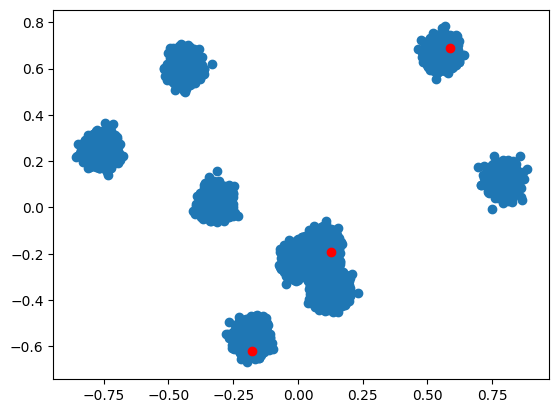

In [23]:
# perform pca of df_embed and plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_embed_pca = pca.fit_transform(df_embed)

df_embed_pca = pd.DataFrame(df_embed_pca, columns=['pca1', 'pca2'])

#plot the 5793, 10805, 2258

plt.scatter(x=df_embed_pca['pca1'], y=df_embed_pca['pca2'])
plt.scatter(df_embed_pca.loc[5793, 'pca1'], df_embed_pca.loc[5793, 'pca2'], color='red')
plt.scatter(df_embed_pca.loc[10805, 'pca1'], df_embed_pca.loc[10805, 'pca2'], color='red')
plt.scatter(df_embed_pca.loc[2258, 'pca1'], df_embed_pca.loc[2258, 'pca2'], color='red')
plt.show()

In [24]:
seed_1 = df_seed.iloc[:,0].to_numpy()
seed_1 = [df_embed.loc[[i]].to_numpy()[0] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

(10, 203)

In [25]:
# perform k means on df_embed using seed points
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, init=seed_1, n_init=1).fit(df_embed)
sc = kmeans.labels_

In [26]:
df_out = pd.DataFrame({'ID':range(11952), 'label':sc})
df_out.to_csv('out.csv', index=False)

## Spectral EMbedding

In [5]:
from sklearn.manifold import SpectralEmbedding
se = SpectralEmbedding(
    n_components=64, affinity='precomputed', n_jobs= -1)
G_se = se.fit_transform(G)

In [6]:
df_attributes_norm = (df_attributes - df_attributes.min()) / (df_attributes.max() - df_attributes.min())
df_attributes_norm

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.305460,0.398193,0.356769,0.912327,0.872622,0.460253,0.260421,0.906014,0.285495,0.693322,...,0.440552,0.403631,0.626342,0.510436,0.733415,0.619425,0.494635,0.393885,0.658841,0.390058
1,0.634351,0.608160,0.331294,0.121064,0.673533,0.663478,0.381219,0.400393,0.326031,0.930007,...,0.294196,0.344390,0.561248,0.396546,0.726069,0.058429,0.385338,0.319743,1.000000,0.128628
2,0.220425,0.485155,0.734805,0.146581,0.178850,0.543948,0.113115,0.899336,0.361504,0.892545,...,0.532325,0.630712,0.370295,0.564086,0.553241,0.344536,0.229711,1.000000,0.558119,0.869803
3,0.304576,0.387888,0.418540,0.360752,0.762113,0.063041,0.638306,0.747999,0.480241,0.740663,...,0.652871,0.633995,0.359904,0.541060,0.538400,0.263281,0.590439,0.393885,0.658841,0.390058
4,0.815897,0.518118,0.641061,0.342213,0.509313,0.621878,0.100645,0.872339,0.126160,0.858296,...,0.495377,0.328448,0.127764,0.638642,0.637960,0.587902,0.640864,0.616752,0.549677,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,0.764486,0.613987,0.663049,0.376621,0.423558,0.963319,0.224748,0.049667,0.344730,0.671741,...,0.187112,0.646951,0.300033,0.321044,0.307411,0.733416,0.503155,0.839730,0.332755,0.613266
11948,0.557053,0.615191,0.358438,0.718763,0.744466,0.978284,0.658188,0.604632,0.687558,0.110519,...,0.471262,0.680014,0.400958,0.485305,0.353089,0.484267,0.539238,0.319743,1.000000,0.128628
11949,0.340027,0.411780,0.413034,0.442228,0.175118,0.398650,0.893118,0.553007,0.865675,0.655396,...,0.591533,0.479920,0.477495,0.383098,0.478810,0.603238,0.514086,0.393885,0.658841,0.390058
11950,0.486540,0.858909,0.563018,0.091992,0.205052,0.511404,0.059749,0.801475,0.321026,0.850250,...,0.416636,0.572304,0.355406,0.622622,0.552128,0.543535,0.566679,0.839730,0.332755,0.613266


In [7]:
df_se = pd.DataFrame(G_se, columns=[i for i in range(64)])

df_se = (df_se - df_se.min()) / (df_se.max() - df_se.min())

df_se_concat = pd.concat([df_attributes_norm, df_se], axis=1)
df_se_concat

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.305460,0.398193,0.356769,0.912327,0.872622,0.460253,0.260421,0.906014,0.285495,0.693322,...,0.325732,0.364416,0.404008,0.442607,0.476786,0.500957,0.472362,0.401303,0.340156,0.421018
1,0.634351,0.608160,0.331294,0.121064,0.673533,0.663478,0.381219,0.400393,0.326031,0.930007,...,0.337602,0.364903,0.394408,0.432665,0.481525,0.500437,0.467749,0.384908,0.344421,0.414729
2,0.220425,0.485155,0.734805,0.146581,0.178850,0.543948,0.113115,0.899336,0.361504,0.892545,...,0.336122,0.373373,0.392196,0.430838,0.469771,0.501692,0.460566,0.387092,0.344325,0.413911
3,0.304576,0.387888,0.418540,0.360752,0.762113,0.063041,0.638306,0.747999,0.480241,0.740663,...,0.330274,0.366726,0.399582,0.434080,0.477244,0.497862,0.448004,0.393328,0.342688,0.420922
4,0.815897,0.518118,0.641061,0.342213,0.509313,0.621878,0.100645,0.872339,0.126160,0.858296,...,0.330415,0.365595,0.400671,0.421068,0.475654,0.495114,0.451175,0.392808,0.343657,0.416336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,0.764486,0.613987,0.663049,0.376621,0.423558,0.963319,0.224748,0.049667,0.344730,0.671741,...,0.326096,0.362491,0.403043,0.418977,0.475004,0.491811,0.464786,0.392087,0.345285,0.415295
11948,0.557053,0.615191,0.358438,0.718763,0.744466,0.978284,0.658188,0.604632,0.687558,0.110519,...,0.330936,0.366286,0.388505,0.435075,0.476706,0.500333,0.468132,0.390676,0.346617,0.420078
11949,0.340027,0.411780,0.413034,0.442228,0.175118,0.398650,0.893118,0.553007,0.865675,0.655396,...,0.329822,0.364414,0.399994,0.416559,0.476782,0.497909,0.466832,0.392959,0.348723,0.418052
11950,0.486540,0.858909,0.563018,0.091992,0.205052,0.511404,0.059749,0.801475,0.321026,0.850250,...,0.322730,0.366403,0.397362,0.427625,0.472269,0.499815,0.466858,0.394933,0.343927,0.419836


### Normal PCA clustering

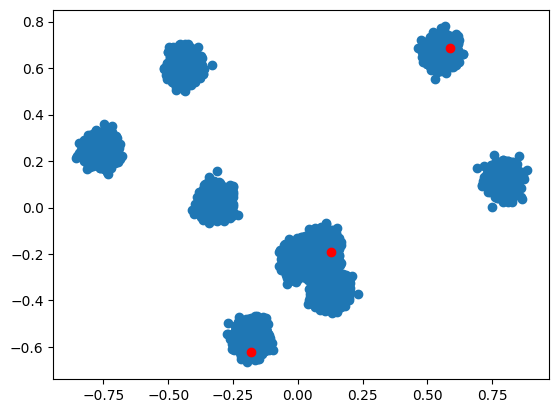

In [8]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_se_pca = pca.fit_transform(df_se_concat)

df_se_concat_pca = pd.DataFrame(df_se_pca, columns=['pca1', 'pca2'])


plt.scatter(x=df_se_concat_pca['pca1'], y=df_se_concat_pca['pca2'])
plt.scatter(df_se_concat_pca.loc[5793, 'pca1'], df_se_concat_pca.loc[5793, 'pca2'], color='red')
plt.scatter(df_se_concat_pca.loc[10805, 'pca1'], df_se_concat_pca.loc[10805, 'pca2'], color='red')
plt.scatter(df_se_concat_pca.loc[2258, 'pca1'], df_se_concat_pca.loc[2258, 'pca2'], color='red')
plt.show()

In [9]:
seed_1 = df_seed.iloc[:,2].to_numpy()
seed_1 = [df_se_concat.loc[[i]].to_numpy()[0] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

(10, 167)

In [10]:
from sklearn.cluster import KMeans

kmeans1 = KMeans(n_clusters=10, init=seed_1).fit(df_se_concat)
sc = kmeans1.labels_
df_out = pd.DataFrame({'ID':range(11952), 'LABEL':sc})
df_out.to_csv('out2.csv', index=False)

### ISOMAP

In [ ]:
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=20, n_components=3)
X_isomap = isomap.fit_transform(df_se_concat)

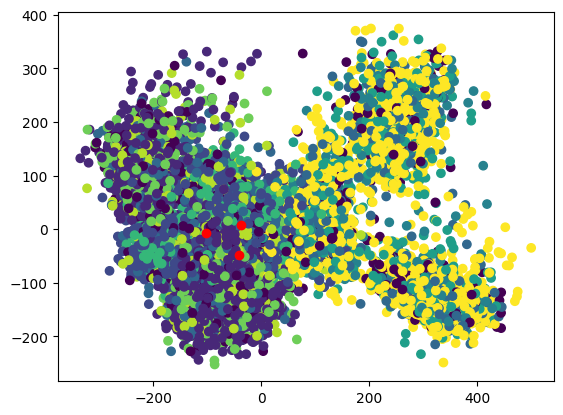

In [84]:
plt.scatter(X_isomap[:, 1], X_isomap[:, 2])
plt.scatter(X_isomap[5793, 1], X_isomap[5793, 2], color='red')
plt.scatter(X_isomap[10805, 1], X_isomap[10805, 2], color='red')
plt.scatter(X_isomap[2258, 1], X_isomap[2258, 2], color='red')
plt.show()

In [61]:
seed_1 = df_seed.iloc[:,1].to_numpy()
seed_1 = [X_isomap[i] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

(10, 3)

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init=seed_1).fit(X_isomap)
sc = kmeans.labels_
df_out = pd.DataFrame({'ID':range(11952), 'LABEL':sc})
df_out.to_csv('out4.csv', index=False)

### t-SNE

In [83]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_se_concat)

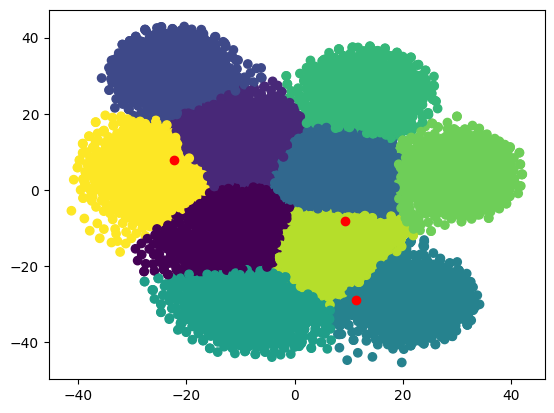

In [92]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.scatter(X_tsne[5793, 0], X_tsne[5793, 1], color='red')
plt.scatter(X_tsne[10805, 0], X_tsne[10805, 1], color='red')
plt.scatter(X_tsne[2258, 0], X_tsne[2258, 1], color='red')
plt.show()

In [89]:
# calculate init seed_1
seed_1 = df_seed.iloc[:,1].to_numpy()
seed_1 = [X_tsne[i] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

(10, 2)

In [90]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init=seed_1).fit(X_tsne)
sc = kmeans.labels_
df_out = pd.DataFrame({'ID':range(11952), 'LABEL':sc})
df_out.to_csv('out5.csv', index=False)

### random projections

In [16]:
from sklearn.random_projection import GaussianRandomProjection
rp = GaussianRandomProjection(n_components=20)
df_rp = rp.fit_transform(df_se_concat)

In [18]:
# calc seed
seed_1 = df_seed.iloc[:,1].to_numpy()
seed_1 = [df_rp[i] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

(10, 20)

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init=seed_1).fit(df_rp)
sc = kmeans.labels_
df_out = pd.DataFrame({'ID':range(11952), 'LABEL':sc})
df_out.to_csv('out6.csv', index=False)

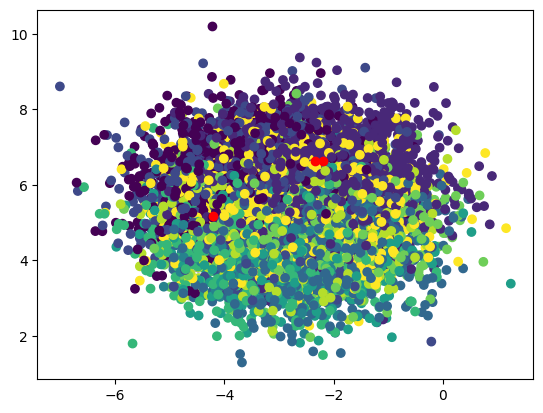

In [15]:
plt.scatter(df_rp[:, 0], df_rp[:, 1])
plt.scatter(df_rp[5793, 0], df_rp[5793, 1], color='red')
plt.scatter(df_rp[10805, 0], df_rp[10805, 1], color='red')
plt.scatter(df_rp[2258, 0], df_rp[2258, 1], color='red')
plt.show()

### LLE

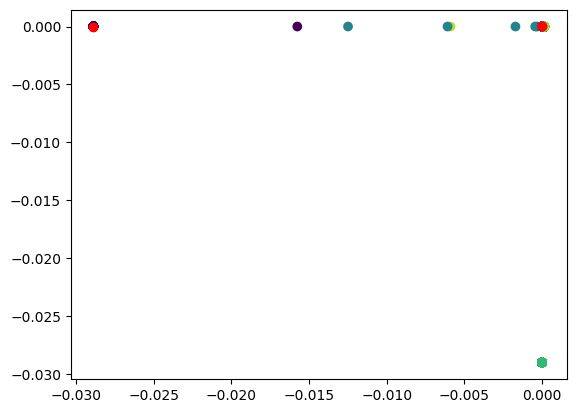

In [21]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2)
X_lle = lle.fit_transform(df_se_concat)
plt.scatter(X_lle[:, 0], X_lle[:, 1])
plt.scatter(X_lle[5793, 0], X_lle[5793, 1], color='red')
plt.scatter(X_lle[10805, 0], X_lle[10805, 1], color='red')
plt.scatter(X_lle[2258, 0], X_lle[2258, 1], color='red')
plt.show()

### Individual ISOMAP

/home/shantanu/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/shantanu/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


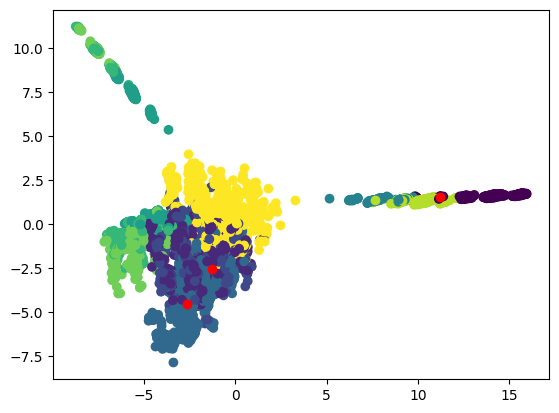

In [32]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2, n_neighbors=10)
X_iso = iso.fit_transform(df_attributes_norm)
plt.scatter(X_iso[:, 0], X_iso[:, 1])
plt.scatter(X_iso[5793, 0], X_iso[5793, 1], color='red')
plt.scatter(X_iso[10805, 0], X_iso[10805, 1], color='red')
plt.scatter(X_iso[2258, 0], X_iso[2258, 1], color='red')
plt.show()

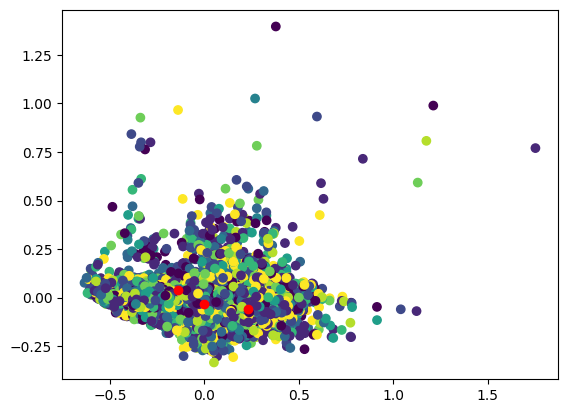

In [31]:
# perform isomap on df_se and plot
from sklearn.manifold import Isomap
iso = Isomap(n_components=2, n_neighbors=10)
# take only first 10 columns
X_iso = iso.fit_transform(df_se.iloc[:, :10])
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=best_labels)
plt.scatter(X_iso[5793, 0], X_iso[5793, 1], color='red')
plt.scatter(X_iso[10805, 0], X_iso[10805, 1], color='red')
plt.scatter(X_iso[2258, 0], X_iso[2258, 1], color='red')
plt.show()

In [34]:
# calculate isomap of df_se and df_attributes seperately and concat
X_iso2 = iso.fit_transform(df_attributes_norm)
X_iso_concat = np.concatenate((df_se.iloc[:, :5], X_iso2), axis=1)

# calc seed for kmeans
seed_1 = df_seed.iloc[:,1].to_numpy()
seed_1 = [X_iso_concat[i] for i in seed_1]
seed_1 = np.array(seed_1)
seed_1.shape

# perform kmeans
kmeans = KMeans(n_clusters=10, init=seed_1).fit(X_iso_concat)
sc = kmeans.labels_
df_out = pd.DataFrame({'ID':range(11952), 'LABEL':sc})
df_out.to_csv('out7.csv', index=False)

/home/shantanu/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/shantanu/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
